# Desafío 2 - PLN - 19 cohorte

**Alumno**: Jose Perez (joseperez190498@gmail.com)

##**Resolución de la consigna**



### Dataset

El dataset utilizado para la resolución de la consigna ha sido descargado de: https://www.kaggle.com/datasets/josemamuiz/noticias-laraznpblico. Este dataset contiene noticias extraídas de los diarios *La Razón* y *Público* de España, categorizados en *Economía*, *Igualdad*, *Política*, *Cultura* y *España*



In [ ]:
# Instalación de librerías
!pip install pandas gensim scikit-learn plotly nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 12.0 MB/s eta 0:00:00


In [ ]:
# Importación de librerías
import pandas as pd
import re
import nltk
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import string
import warnings
from tensorflow.keras.preprocessing.text import text_to_word_sequence
import multiprocessing

warnings.filterwarnings('ignore')

In [ ]:
# ----- 0. Función de preprocesamiento -----
try:
    print("Descargando recursos de NLTK...")
    nltk.download('punkt')
    nltk.download('punkt_tab')
    nltk.download('stopwords')
    nltk.download('wordnet')
    print("Todos los recursos de NLTK actualizados...!!!")
except Exception as e:
    print(f"Error descargando NLTK: {e}")


def preprocesar_texto(text):
    """
    Clean → Tokenization → Lemmatization → Remove stopwords → Remove punctuation
    """
        # 0. Limpiar texto
    cleaned_text = str(text).lower()
    cleaned_text = re.sub(r'https?://\S+|www\.\S+', ' ', cleaned_text) # Elimina URLs
    cleaned_text = re.sub(r'[^a-záéíóúüñ\s]', ' ', cleaned_text) # Solo letras y espacios

    # 1. Tokenization
    nltk_tokenList = word_tokenize(cleaned_text)

    # 2. Lemmatization
    lemmatizer = WordNetLemmatizer()
    nltk_lemmaList = []
    for word in nltk_tokenList:
        nltk_lemmaList.append(lemmatizer.lemmatize(word))

    # 3. Elminar Stop words
    nltk_stop_words = set(stopwords.words("spanish"))
    filtered_sentence = [w for w in nltk_lemmaList if w not in nltk_stop_words]

    # 4. Filtrar puntuación
    filtered_sentence = [w for w in filtered_sentence if w not in string.punctuation]

    return filtered_sentence

Descargando recursos de NLTK...
Todos los recursos de NLTK actualizados...!!!


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


* **Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset.**


In [ ]:
# ----- 1. Cargar y preprocesar data del csv cargado -----

# Leer csv
df = pd.read_csv('data_larazon_publico_v2.csv')

# Eliminar filas donde cuerpo es vacío
df.dropna(subset=['cuerpo'], inplace=True)

df_sample = df.sample(frac=0.2, random_state=42)
print(df_sample.info)

# Preprocesar la columna cuerpo
sentence_tokens = [preprocesar_texto(cuerpo) for cuerpo in df_sample['cuerpo']]

# Filtrar cualquier lista vacía que pueda resultar del procesamiento
sentence_tokens = [tokens for tokens in sentence_tokens if tokens]

print(f"\n{len(sentence_tokens)} noticias procesadas.")
print(f"\nEjemplo de una sentencia (noticia) tokenizada: {sentence_tokens[0]}")


<bound method DataFrame.info of        Unnamed: 0   indi                                             cuerpo  \
35368       35368   3894  la compañía de tecnología y consultoría indra ...   
6515         6515   1438  hace poco menos de un mes, una extraña carta l...   
38676       38676   3252  nuclenor (sociedad participada al 50% por iber...   
14311       14311    413  la sentencia de los ere, la primera de varias ...   
24449       24449   2372  el pleno del congreso de los diputados de este...   
...           ...    ...                                                ...   
19876       19876   1230  preludio. esa es la palabra que viene a la cab...   
44071       44071   3987  el temido colapso sanitario por la covid-19 am...   
5881         5881    802  la población tunecina (697) es mayoritaria den...   
55818       55819  15818  el govern prevé denunciar ante la fiscalía al ...   
50771       50772  10745  el secretario general del pp de melilla, migue...   

                   

**Comentario:** Se define la función *procesar_texto* que implementa un pipeline de preprocesamiento con NLTK. El proceso inicia con una fase de limpieza y normalización del cuerpo. Posteriormente, se realiza la *tokenización* y la *lematización* para reducir cada término a su forma base. Después, se realiza un filtrado para descartar tanto las stopwords como cualquier signo de puntuación residual.

In [ ]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [ ]:
# ----- 2. Crear y entrenar el modelo Word2Vec -----
print("Entrenando el modelo Word2Vec...\n")

# Crear modelo generador de vectores
w2v_model = Word2Vec(
    min_count=5,
    window=2,
    vector_size=300,
    workers=multiprocessing.cpu_count(),
    sg=1  # 1 para modelo Skip-gram
)

# Construir el vocabulario a partir de los tokens
w2v_model.build_vocab(sentence_tokens)
print(f"Vocabulario construido con {len(w2v_model.wv.index_to_key)} palabras únicas.\n")

# Entrenar el modelo
w2v_model.train(
    sentence_tokens,
    total_examples=w2v_model.corpus_count,
    epochs=30,
    compute_loss = True,
    callbacks=[callback()]
)

print("Entrenamiento del modelo completado...!\n")

# Guardar el modelo
w2v_model.save("word2vec_news.model")
print("Modelo guardado con el nombre 'word2vec_news.model'\n")


Entrenando el modelo Word2Vec...

Vocabulario construido con 32708 palabras únicas.

Loss after epoch 0: 11405601.0
Loss after epoch 1: 7449767.0
Loss after epoch 2: 6861524.0
Loss after epoch 3: 6535658.0
Loss after epoch 4: 4766662.0
Loss after epoch 5: 4193984.0
Loss after epoch 6: 4087900.0
Loss after epoch 7: 3985108.0
Loss after epoch 8: 3949480.0
Loss after epoch 9: 3814556.0
Loss after epoch 10: 3831500.0
Loss after epoch 11: 3744796.0
Loss after epoch 12: 2676408.0
Loss after epoch 13: 615544.0
Loss after epoch 14: 598384.0
Loss after epoch 15: 594464.0
Loss after epoch 16: 573160.0
Loss after epoch 17: 564056.0
Loss after epoch 18: 553152.0
Loss after epoch 19: 542360.0
Loss after epoch 20: 537936.0
Loss after epoch 21: 526184.0
Loss after epoch 22: 508480.0
Loss after epoch 23: 505832.0
Loss after epoch 24: 485312.0
Loss after epoch 25: 478328.0
Loss after epoch 26: 472704.0
Loss after epoch 27: 459856.0
Loss after epoch 28: 451056.0
Loss after epoch 29: 437200.0
Entrenamien

**Comentario:** El resultado del entrenamiento del modelo demuestra un proceso de convergencia relativamente exitoso. Partiendo de un vocabulario de más de 32 000 palabras únicas y que la función de pérdida exhibe una tendencia decreciente a lo largo de las 30 épocas, lo que indica que el modelo está aprendiendo patrones semánticos del corpus, sugiriendo que el modelo alcanza un punto de optimización adecuado.

* **Probar términos de interés y explicar similitudes en el espacio de embeddings (sacar conclusiones entre palabras similitudes y diferencias).**


In [ ]:
from gensim.models import Word2Vec

# Cargar el modelo
model = Word2Vec.load('word2vec_news.model')
print("Modelo cargado...!\n")

Modelo cargado...!



In [ ]:
from sklearn.metrics import pairwise
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def get_most_similar_w (model: Word2Vec, words:list):
  for w in words:
    print(f"--- TEST: Palabras similares a {w} ---")
    print(model.wv.most_similar(positive=[w], topn=7))
    print("\n")

def get_w_embeddings (model: Word2Vec, words: list):
  vector_size = model.vector_size
  embeddings = []
  for w in words:
    if w in model.wv:
      embeddings.append(model.wv[w])
    else:
      embeddings.append(np.zeros(vector_size))
  return np.vstack(embeddings)

In [ ]:
test_words = ['españa', 'congreso', 'cultura', 'economía', 'periódico']

get_most_similar_w(model, test_words)

--- TEST: Palabras similares a españa ---
[('incipientes', 0.38616642355918884), ('auza', 0.37093430757522583), ('regresara', 0.36295121908187866), ('desgobernadosbaleares', 0.35197925567626953), ('nórdicos', 0.3487876057624817), ('hispanoamérica', 0.3400317132472992), ('ia', 0.3383564054965973)]


--- TEST: Palabras similares a congreso ---
[('diputados', 0.5600146055221558), ('cámara', 0.5580068230628967), ('senado', 0.5411327481269836), ('parlamento', 0.44036608934402466), ('debatirse', 0.41410255432128906), ('votara', 0.4131537675857544), ('parlamentaria', 0.4112364947795868)]


--- TEST: Palabras similares a cultura ---
[('deporte', 0.37873032689094543), ('pop', 0.3787125051021576), ('ciencia', 0.3735942542552948), ('dilatada', 0.36092519760131836), ('antonia', 0.3544655442237854), ('educación', 0.34932950139045715), ('agricultura', 0.3479132056236267)]


--- TEST: Palabras similares a economía ---
[('competitividad', 0.40509679913520813), ('desaceleración', 0.3938645124435425), (

**Comentario:** El modelo de embeddings demuestra un rendimiento variable, que depende básicamente de lo específico relacionado a la semántica de cada palabra en el corpus. Por ejemplo, exhibe una notable capacidad para capturar el contexto de conceptos bien definidos como *congreso*, que se asocia con un scope léxico como *diputados, senado, parlamento* y con *periódico* que se vincula a *diario, larazon, vozpopuli*. Sin embargo, también muestra dificultades con términos semánticamente más amplios como *españa* que tiende a representar conceptos más generales.

In [ ]:
def perform_analogy(positive_words, negative_words):
    """
    Función auxiliar para realizar analogías
    """
    # Muestra la fórmula de la analogía que se está probando.
    formula = f"{' + '.join(positive_words)} - {''.join(negative_words)}"
    print(f"Probando Fórmula: {formula}")

    try:
        result = model.wv.most_similar(positive=positive_words, negative=negative_words, topn=10)
        print(f"Resultado: {result}\n")
    except KeyError as e:
        print(f"Error: La palabra {e} no está en el vocabulario del modelo.\n")

# --- Analogía 1: Género y Realeza ---
perform_analogy(positive_words=["rey", "reina"], negative_words=["hombre"])

# --- Analogía 2: Geografía ---
perform_analogy(positive_words=["españa", "portugal"], negative_words=["madrid"])

# --- Analogía 3: Conceptos ---
perform_analogy(positive_words=["economía", "cultura"], negative_words=["dinero"])

Probando Fórmula: rey + reina - hombre
Resultado: [('emérito', 0.5194422602653503), ('monarca', 0.42250338196754456), ('letizia', 0.40785887837409973), ('hussein', 0.3933655023574829), ('abdalá', 0.387633353471756), ('salman', 0.38481247425079346), ('vi', 0.3841986060142517), ('carlosespaña', 0.3611869215965271), ('zarzuela', 0.3478972315788269), ('examiga', 0.3460576832294464)]

Probando Fórmula: españa + portugal - madrid
Resultado: [('reconociera', 0.35572266578674316), ('nórdicos', 0.3486238718032837), ('estonia', 0.3437994122505188), ('jordania', 0.34076401591300964), ('latinoamérica', 0.33626917004585266), ('bielorrusia', 0.3343985676765442), ('eslovenia', 0.33414027094841003), ('chipre', 0.3334166705608368), ('dinamarca', 0.3322995603084564), ('yugoslavia', 0.3275893032550812)]

Probando Fórmula: economía + cultura - dinero
Resultado: [('agricultura', 0.3295537531375885), ('ciencia', 0.3247700035572052), ('valdeolivas', 0.30289801955223083), ('emprendimiento', 0.3001625537872314

**Comentario:** los resultados de las analógias demuestran una capacidad notable del modelo para corresponder una lógica semántica, pero no del todo precisa aún. El primer test aisla exitosamente el concepto de "realeza", devolviendo términos como *monarca, emérito* y nombres reales de reinas como *letizia*. De forma similar, la tercera analogía produce como resultado otros sectores claves como la *agricutura, ciencia e industria*, demostrando que el modelo puede diferir conceptos categóricos. Aunque la segunda analogía es menos precisa, su resultado indica también que el modelo entiende la operación a nivel categórica.

* **Graficarlos.**

In [ ]:
import numpy as np
import plotly.express as px
from sklearn.manifold import TSNE

def reduce_dimensions(model, num_dimensions=2):
    """
    Reduce la dimensionalidad de los vectores para poder graficarlos.
    """
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    # Usamos t-SNE para la reducción.
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors_reduced = tsne.fit_transform(vectors)
    return vectors_reduced, labels

print("Reduciendo dimensiones con t-SNE para la visualización...")
vecs, labels = reduce_dimensions(model)
print("Dimensiones reducidas.")

# Graficamos las primeras 250 palabras para que el gráfico sea legible.
MAX_WORDS = 250
fig = px.scatter(
    x=vecs[:MAX_WORDS, 0],
    y=vecs[:MAX_WORDS, 1],
    text=labels[:MAX_WORDS]
)
# Añadimos títulos en español al gráfico.
fig.update_layout(
    title="Visualización 2D de Embeddings de Noticias en Español",
    xaxis_title="Dimensión 1",
    yaxis_title="Dimensión 2"
)
fig.show()

In [ ]:
def plot_word_and_neighbors(target_word, model, topn=10):
    """
    Encuentra los 'topn' vecinos más cercanos de una palabra,
    reduce su dimensionalidad con t-SNE y los grafica.
    """
    try:
        # --- 1. Encontrar los vecinos y recolectar las palabras ---
        # Añadimos la palabra objetivo a la lista de sus vecinos.
        words_to_plot = [target_word]
        # Obtenemos los vecinos más cercanos.
        similar_words = model.wv.most_similar(target_word, topn=topn)
        # Añadimos solo los nombres de las palabras vecinas a nuestra lista.
        words_to_plot.extend([word for word, score in similar_words])

        # --- 2. Obtener los vectores de todas esas palabras ---
        vectors = model.wv[words_to_plot]

        # --- 3. Reducir la dimensionalidad de SOLO estos vectores a 2D ---
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(10, len(vectors)-1))
        vectors_2d = tsne.fit_transform(vectors)

        # --- 4. Crear el gráfico con Plotly ---
        # Creamos una lista para diferenciar la palabra objetivo de sus vecinos.
        types = ['Palabra Objetivo'] + ['Vecino Cercano'] * topn

        fig = px.scatter(
            x=vectors_2d[:, 0],
            y=vectors_2d[:, 1],
            text=words_to_plot,
            color=types,
            color_discrete_map={
                'Palabra Objetivo': 'red',
                'Vecino Cercano': 'blue'
            }
        )

        # Personalizamos el gráfico para que sea más claro
        fig.update_traces(textposition='top center', marker={'size': 10})
        fig.update_layout(
            title=f"Vecinos más Cercanos de '{target_word}'",
            xaxis_title="Dimensión 1 (t-SNE)",
            yaxis_title="Dimensión 2 (t-SNE)",
            showlegend=True
        )
        fig.show()

    except KeyError:
        print(f"Error: La palabra '{target_word}' no se encuentra en el vocabulario del modelo.")

plot_word_and_neighbors("españa", model)
plot_word_and_neighbors("diputados", model)
plot_word_and_neighbors("cultura", model)
plot_word_and_neighbors("deportes", model)
plot_word_and_neighbors("economía", model)

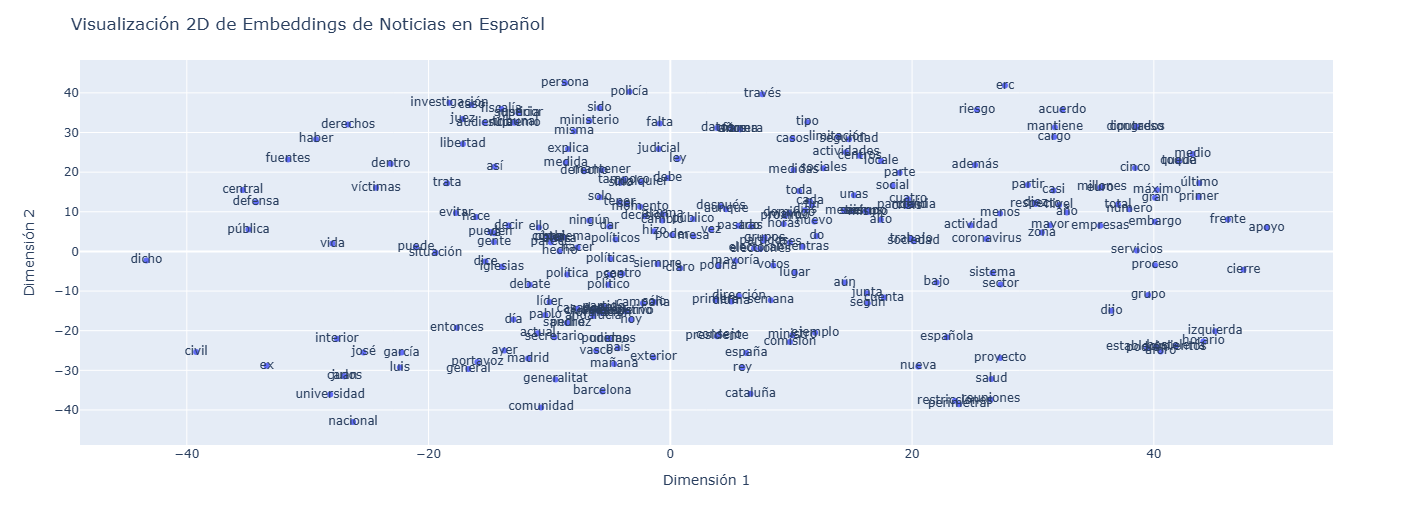

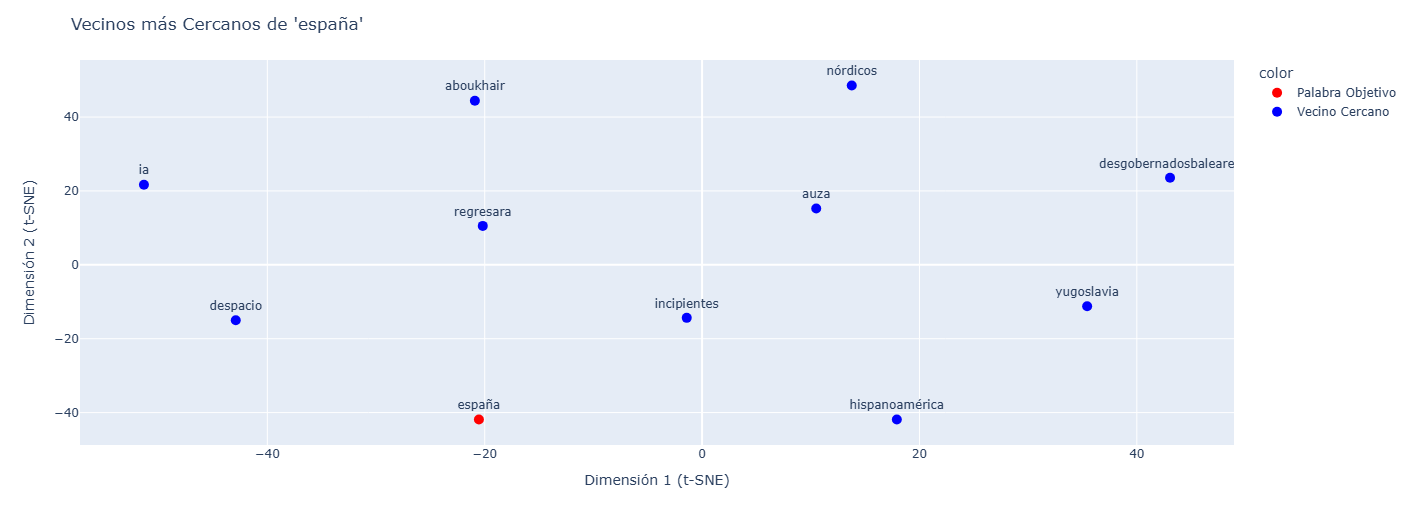

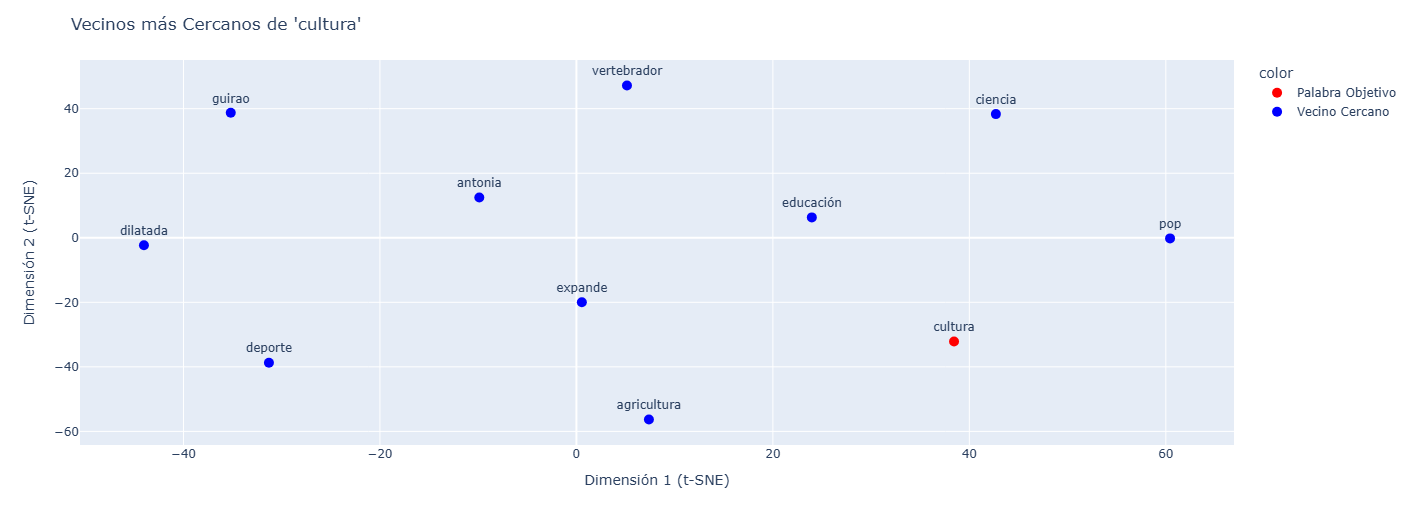

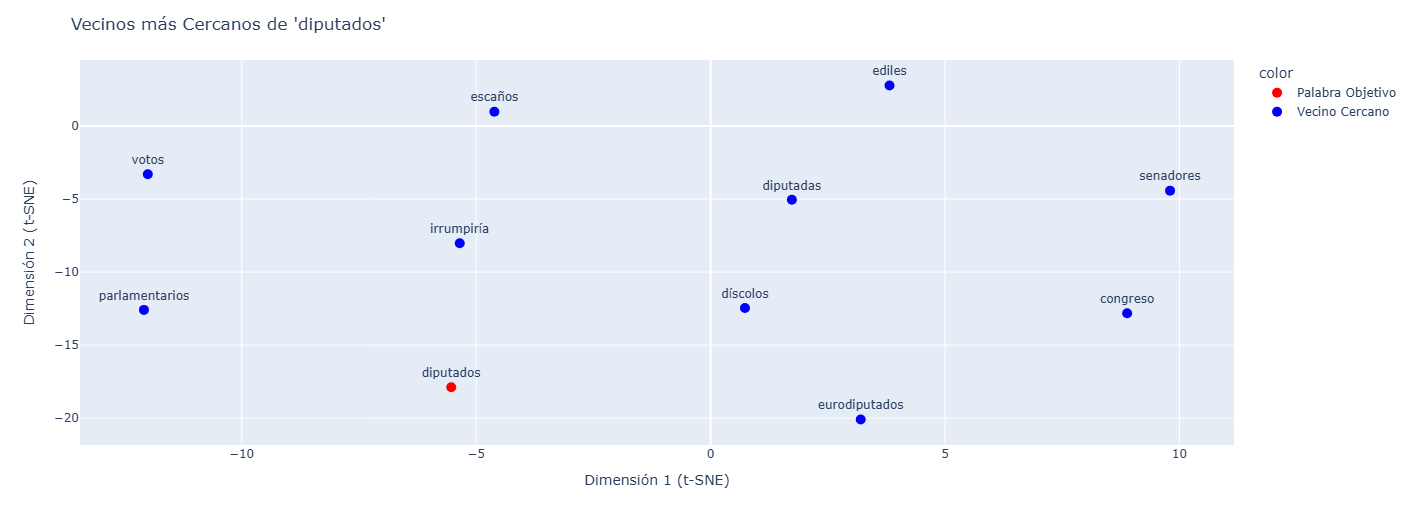

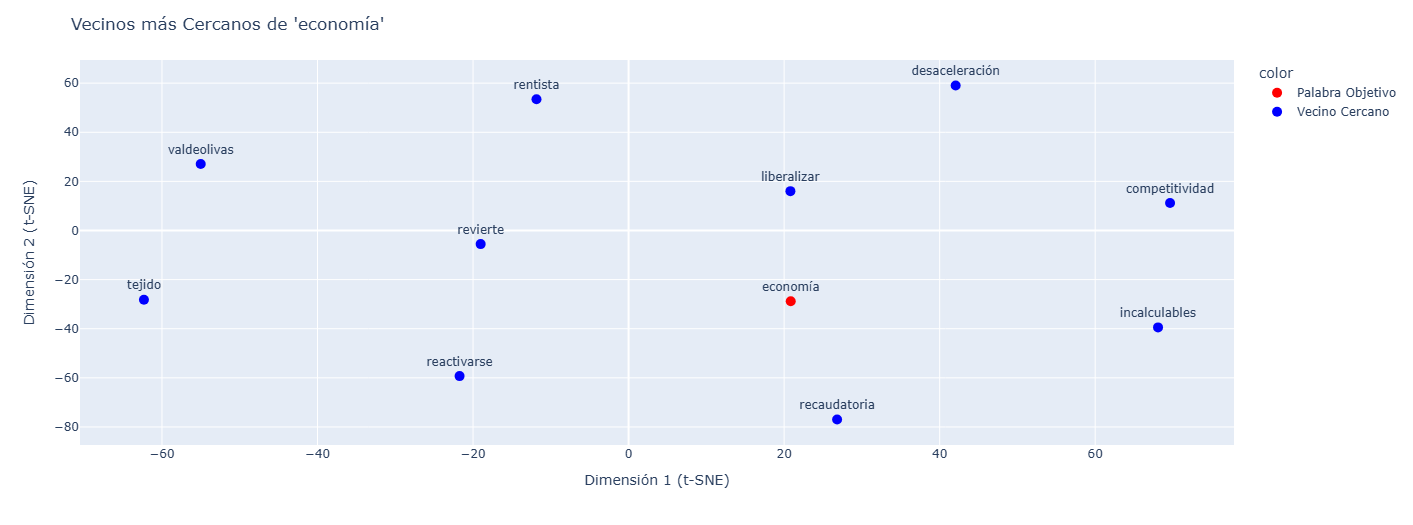

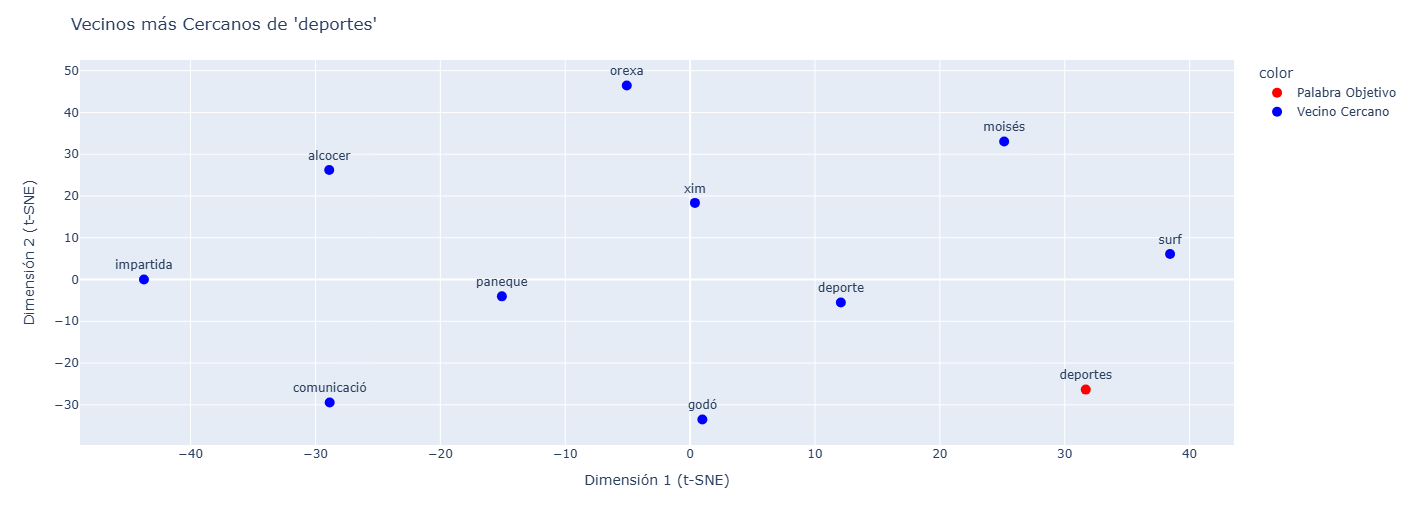

In [ ]:
# Mostrar imágenes resultantes como png estático para visualización en Git
from IPython.display import Image

images_list = ["news.png", "españa.png", "cultura.png", "diputados.png", "economía.png", "deportes.png"]

for image in images_list:
  display(Image(filename=image))

**Comentario:** A partir de los gráficos se puede evidenciar la formación de "clusters" o agrupaciones de palabras, donde los términos con significados o contextos similares aparecen unos cerca de otros. Se observa islas temáticas bien definidas en los casos donde las palabras objetivos son *diputados* o *economía*. Esto puede deberse a que la mayoría de las noticias del dataset están relacionadas a política o economía en general, lo que de cierta manera afecta al modelo a generar una estructura semántica coherente en el espacio vectorial respecto a estos temas.

* **Conclusiones.**

1. A partir del ejercicio, se evidencia que la calidad y cantidad del dataset son los factores más determinantes para el éxito del modelo. Asimismo, la implementación de un pipeline de preprocesamiento específico para el idioma (*spanish*), utilizando NLTK, es fundamental para normalizar el vocabulario y consolidar el significado de las palabras.

2. Se construyó un espacio vectorial donde las palabras son vectores que codifican significado, es decir, que la distancia entre estos representa una similitud semántica.

3. Se validó el modelo y la calidad de los embeddings a partir de la convergencia de la función de pérdida durante el entrenamiento, evaluando la lógica de los vecinos más cercanos para términos de interés, comprobando la capacidad del modelo en relacionar palabras a través de analogías y confirmar la estructura de clusters temáticos mediante t-SNE.